In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt


In [4]:
# Attempt to unzip zipped file, failed
#import gzip
#with gzip.open('fashion_mnist/train-images-idx3-ubyte.gz') as f:

learning_set = np.fromfile('fashion_mnist/train-images-idx3-ubyte', dtype='uint8')
learning_lab = np.fromfile('fashion_mnist/train-labels-idx1-ubyte', dtype='uint8')
test_set = np.fromfile('fashion_mnist/t10k-images-idx3-ubyte', dtype='uint8')
test_lab = np.fromfile('fashion_mnist/t10k-labels-idx1-ubyte', dtype='uint8')

In [5]:
learning_set.shape

(47040016,)

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
print(learning_set[4:8])

[  0   0 234  96]


Preprocessing MNIST data into separate folders

In [7]:
# Importing PIL for image manipulation
import PIL

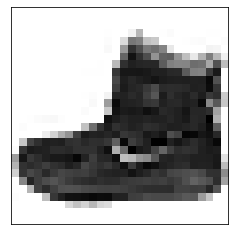

In [8]:
plt.grid(False)
plt.xticks([])
plt.yticks([])  
img = np.reshape(learning_set[range(16,28*28+16)], (28,28))
plt.imshow(img, cmap=plt.cm.binary)

In [9]:
np.reshape(learning_set[16:], (60000, 28, 28, 1)).shape

(60000, 28, 28, 1)

In [10]:
# Loading data straight from folders, will work in 2.4.0

# fashion_mnist_train = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     labels="inferred",import tensorflow as tf

#     label_mode="int",
#     class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot'],
#     color_mode='grayscale',
#     batch_size=32,
#     image_size=(28, 28),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
# )

# fashion_mnist_test = tf.keras.preprocessing.image_dataset_from_directory(
#     test_path,
#     labels="inferred",
#     label_mode="int",
#     class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot'],
#     color_mode='grayscale',
#     batch_size=32,
#     image_size=(28, 28),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
# )

In [11]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_examples = 60000
test_examples = 10000
train_dataset = tf.data.Dataset.from_tensor_slices(
    (np.reshape(learning_set[16:], (60000, 28, 28, 1)), # Input
     learning_lab[8:]) # Output
)
test_dataset  = tf.data.Dataset.from_tensor_slices(
    (np.reshape(test_set[16:], (10000, 28, 28, 1)), # Input
     test_lab[8:]) # Output
)


Testing whether dataset was loaded properly, should show a boot:

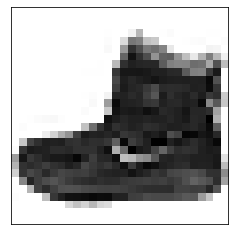

In [7]:
plt.grid(False)
plt.xticks([])
plt.yticks([])  
img = np.reshape(train_dataset.as_numpy_iterator().next()[0], (28,28))
plt.imshow(img, cmap=plt.cm.binary)

Dataset loaded, learning time

In [12]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [21]:
#layerInput = tf.keras.layers.Input(shape=(28, 28, 1))
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(.1, input_shape=(28,28,32*64)),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(.1, input_shape=(28,28,32*64)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [22]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [21]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4187 - accuracy: 0.8480
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2684 - accuracy: 0.9008
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2246 - accuracy: 0.9174
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1935 - accuracy: 0.9285
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1650 - accuracy: 0.9389
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1410 - accuracy: 0.9479
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1230 - accuracy: 0.9547
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1057 - accuracy: 0.9607
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0902 - accuracy: 0.9670
Epoch 10/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.076

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.2425 - accuracy: 0.9259
Accuracy on test dataset: 0.9258999824523926


In [16]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
    

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  dropout (Dropout)            (None, 14, 14, 64)        0
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [17]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

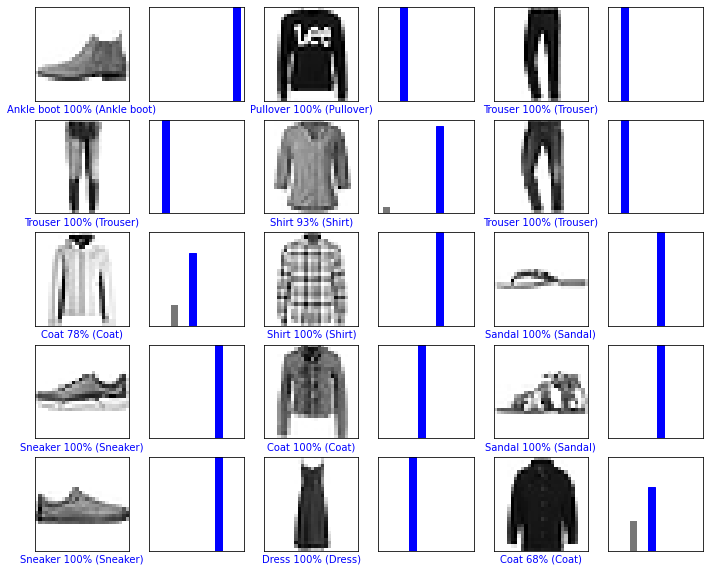

In [18]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Model U-net

In [1]:
'''
#
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time

global batch_size  ########################################
batch_size = 32

def deconv2d(input_, output_shape,
             k_h=3, k_w=3, d_h=2, d_w=2, stddev=0.02,
             name='deconv2d', init_bias=0.):
  """Creates deconvolutional layers.
  Args:
    input_: 4D input tensor (batch size, height, width, channel).
    output_shape: Number of features in the output layer.
    k_h: The height of the convolutional kernel.
    k_w: The width of the convolutional kernel.
    d_h: The height stride of the convolutional kernel.
    d_w: The width stride of the convolutional kernel.
    stddev: The standard deviation for weights initializer.
    name: The name of the variable scope.
    init_bias: The initial bias for the layer.
  Returns:
    conv: The normalized tensor.
  """
  with tf.variable_scope(name):
    w = tf.get_variable('w',
                        [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                        initializer=tf.random_normal_initializer(stddev=stddev))
    deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                    strides=[1, d_h, d_w, 1])
    biases = tf.get_variable('biases', [output_shape[-1]],
                             initializer=tf.constant_initializer(init_bias))
    deconv = tf.nn.bias_add(deconv, biases)
    deconv.shape.assert_is_compatible_with(output_shape)

    return deconv

def Network (Input1,Input2): #input1 : [Batch_size, 256, 256, 3], input2 : [Batch_size, 64, 64, 3]
    
    
    sess = tf.Session()
    
    
    with tf.name_scope ("Encoder"):
        
        
        
        conv1_1 = tf.layers.conv2d(Input1, filters = 64, 
                                   kernel_size = 3, strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv1_1') #[32, 256, 256, 64]
        conv1_2 = tf.layers.conv2d(conv1_1, filters = 64, 
                                   kernel_size = 3, strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv1_2') #[32, 256, 256, 64]
        pool1 = tf.layers.max_pooling2d(conv1_2, pool_size = 2,
                                   strides = 2, padding='SAME', name = 'pool1') #[32, 128, 128, 64]
        
        
        
        conv2_1 = tf.layers.conv2d(pool1, filters = 128, 
                                   kernel_size = 3, strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv2_1')  #[32, 128, 128, 128]
        conv2_2 = tf.layers.conv2d(conv2_1, filters = 128, 
                                   kernel_size = 3, strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv2_2')  #[32, 128, 128, 128]
        pool2 = tf.layers.max_pooling2d(conv2_2, pool_size = 2, 
                                   strides = 2, padding='SAME', name = 'pool2')  #[32, 64, 64, 128]
        
        
        
        conv3_1 = tf.layers.conv2d(pool2, filters = 256, kernel_size = 3, 
                                   strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv3_1') #[32, 64, 64, 256]
        conv3_2 = tf.layers.conv2d(conv3_1, filters = 256, 
                                   kernel_size = 3, strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv3_2')  #[32, 64, 64, 256]
        pool3 = tf.layers.max_pooling2d(conv3_2, pool_size = 2, 
                                   strides = 2, padding='SAME', name = 'pool3')  #[32, 32, 32, 256]
        
        
        
        conv4_1 = tf.layers.conv2d(pool3, filters = 512, kernel_size = 3, #
                                   strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv4_1')  #[32, 32, 32, 512]
        conv4_2 = tf.layers.conv2d(conv4_1, filters = 512, kernel_size = 3, 
                                   strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv4_2')  #[32, 32, 32, 512]
        pool4 = tf.layers.max_pooling2d(conv4_2, pool_size = 2, 
                                   strides = 2, padding='SAME', name = 'pool4')  #[32, 16, 16, 512]
        
        
        
        conv5_1 = tf.layers.conv2d(pool4, filters = 512, kernel_size = 3, 
                                   strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv5_1')  #[32, 16, 16, 512]
        conv5_2 = tf.layers.conv2d(conv5_1, filters = 512, kernel_size = 3, 
                                   strides = 1, padding='SAME', 
                                   activation = tf.nn.relu, name = 'conv5_2')  #[32, 16, 16, 512]
        pool5 = tf.layers.max_pooling2d(conv5_2, pool_size = 2, 
                                   strides = 2, padding='SAME', name = 'pool5')  #[32, 8, 8, 512]
        
       
        
    with tf.name_scope("Conditional"):
        
        
        
        Bconv1_1 = tf.layers.conv2d(Input2, filters = 32, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv1_1') #[32, 64, 64, 32]
        Bconv1_2 = tf.layers.conv2d(Bconv1_1, filters = 32, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv1_2') #[32, 64, 64, 32]
        Bpool1 = tf.layers.max_pooling2d(Bconv1_2, pool_size = 2, 
                                    strides = 2, padding='SAME', name = 'Bpool1')  #[32, 32, 32, 32]
        
        
        
        Bconv2_1 = tf.layers.conv2d(Bpool1, filters = 64, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv2_1')  #[32 32, 32, 64]
        Bconv2_2 = tf.layers.conv2d(Bconv2_1, filters = 64, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv2_2')  #[32, 32, 32, 64]
        Bpool2 = tf.layers.max_pooling2d(Bconv2_2, pool_size = 2, 
                                    strides = 2, padding='SAME', name = 'Bpool2') #[32, 16, 16, 64]
        
        
        
        Bconv3_1 = tf.layers.conv2d(Bpool2, filters = 128, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv3_1')  #[32, 16, 16, 128]
        Bpool3 = tf.layers.max_pooling2d(Bconv3_1, pool_size = 2, 
                                    strides = 2, padding='SAME', name = 'Bpool3')  #[32, 8, 8, 128]
        
        
        
        Bconv4_1 = tf.layers.conv2d(Bpool3, filters = 256, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv4_1')  #[32, 8, 8, 256]
        Bpool4 = tf.layers.max_pooling2d(Bconv4_1, pool_size = 2, 
                                    strides = 2, padding='SAME', name = 'Bpool4')  #[32, 4, 4, 512]
        
        
        
        Bconv5_1 = tf.layers.conv2d(Bpool4, filters = 512, kernel_size = 3, 
                                    strides = 1, padding='SAME', 
                                    activation = tf.nn.relu, name = 'Bconv5_1')  #[32, 4, 4, 512]
        Bpool5 = tf.layers.max_pooling2d(Bconv5_1, pool_size = 2, 
                                    strides = 2, padding='SAME', name = 'Bpool5')  #[32, 2, 2, 512]
        
        
        Bconv6 = tf.layers.conv2d(Bpool5, filters = 512, kernel_size = 2, 
                                    strides = 1, activation = tf.nn.relu, name = 'Bconv6') #[32, 1, 1, 512]
        
        
  
        Btile1=tf.tile(Bconv6,[1,pool5.get_shape().as_list()[1],pool5.get_shape().as_list()[2],1])  #[32, 8, 8, 512]
    
        Btile2=tf.tile(Bconv6,[1,conv5_2.get_shape().as_list()[1],conv5_2.get_shape().as_list()[2],1]) #[32, 16, 16, 512]
         
        Btile3=tf.tile(Bconv6,[1,conv4_2.get_shape().as_list()[1],conv4_2.get_shape().as_list()[2],1])  #[32, 32, 32, 512]
        
        Btile4=tf.tile(Bconv6,[1,conv3_2.get_shape().as_list()[1],conv3_2.get_shape().as_list()[2],1])  #[32, 64, 64, 512]
        
        Btile5=tf.tile(Bconv6,[1,conv2_2.get_shape().as_list()[1],conv2_2.get_shape().as_list()[2],1])  #[32, 128, 128, 512]
        
        
       
        
    with tf.name_scope("Decoder"):
        
        
        #concatination
        efused_1= tf.concat([pool5,Btile1],-1, name='efused_1')  #[32, 8, 8, 1024]
        
        #3x3 convolution + 3x3 convolution + 2x2 upsampling
        Dconv1_1=tf.layers.conv2d(efused_1, filters=512, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv1_1')  #[32, 8, 8, 512]
        
        Dconv1_2=tf.layers.conv2d(Dconv1_1, filters=512, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv1_2')  #[32, 8, 8, 512]
        
        upsam1=tf.nn.relu(deconv2d(Dconv1_2, [batch_size,16,16,512], name='upsam1')) #[32, 16, 16, 512]]
     
    
    
        #concatination
        efused_2= tf.concat([conv5_2,Btile2],-1, name='efused_2')  #[32, 16, 16, 1024]
        
        #1x1 convolution
        fconv_1 = tf.layers.conv2d(efused_2, filters = 512, kernel_size = 1, 
                                            strides = 1, padding='SAME', 
                                            activation = tf.nn.relu, name = 'fconv_1')  #[32, 16, 16, 512]
        #concatination
        dfused_2= tf.concat([upsam1 ,fconv_1],-1, name='dfused_2')  #[32, 16, 16, 1024]
        
        #3x3 convolution + 3x3 convolution + 2x2 upsampling
        Dconv2_1=tf.layers.conv2d(dfused_2, filters=512, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv2_1')  #[32, 16, 16, 512]
        
        Dconv2_2=tf.layers.conv2d(Dconv2_1, filters=512, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv2_2')  #[32, 16, 16, 512]
        
        upsam2 =tf.nn.relu(deconv2d(Dconv2_2, [batch_size,32,32,512], name='upsam2')) #[32, 32, 32, 512]

        
        
        
        #concatination
        efused_3= tf.concat([conv4_2,Btile3],-1, name='efused_3')  #[32, 32, 32, 1024]
        
        #1x1 convolution
        fconv_2 = tf.layers.conv2d(efused_3, filters = 256, kernel_size = 1, 
                                           strides = 1, padding='SAME', 
                                           activation = tf.nn.relu, name = 'fconv_2')  #[32, 32, 32, 256]
        #concatination
        dfused_3= tf.concat([upsam2 ,fconv_2],-1, name='dfused_3')  #[32, 32, 32, 768]
        
        #3x3 convolution + 3x3 convolution + 2x2 upsampling
        Dconv3_1=tf.layers.conv2d(dfused_3, filters=256, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv3_1')  #[32, 32, 32, 256]
        
        Dconv3_2=tf.layers.conv2d(Dconv3_1, filters=256, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv3_2')  #[32, 32, 32, 256]
        
        upsam3 = tf.nn.relu(deconv2d(Dconv3_2, [batch_size,64,64,256], name='upsam3'))  #[32, 64, 64, 256]

        
    
    
    
        #concatination
        efused_4= tf.concat([conv3_2,Btile4],-1, name='efused_4')  #[32, 64, 64, 768]
        
        #1x1 convolution
        fconv_3 = tf.layers.conv2d(efused_4, filters = 128, kernel_size = 1, 
                                           strides = 1, padding='SAME', 
                                           activation = tf.nn.relu, name = 'fconv_3')  #[32, 64, 64, 128]
        #concatination
        dfused_4= tf.concat([upsam3 ,fconv_3],-1, name='dfused_4')  #[32, 64, 64, 384]
        
        #3x3 convolution + 3x3 convolution + 2x2 upsampling
        Dconv4_1=tf.layers.conv2d(dfused_4, filters=128, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv4_1')  #[32, 64, 64, 128]
        
        Dconv4_2=tf.layers.conv2d(Dconv4_1, filters=128, kernel_size=3, 
                                             strides=1, padding='SAME',
                                            activation=tf.nn.relu, name='Dconv4_2')  #[32, 64, 64, 128]
        
        upsam4 = tf.nn.relu(deconv2d(Dconv4_2, [batch_size,128,128,128], name='upsam4'))  #[32, 128, 128, 128]
 





        #concatination
        efused_5= tf.concat([conv2_2,Btile5],-1, name='efused_5')  #[32, 128, 128, 640]
        
        #1x1 convolution
        fconv_4 = tf.layers.conv2d(efused_5, filters = 64, kernel_size = 1, 
                                           strides = 1, padding='SAME', 
                                           activation = tf.nn.relu, name = 'fconv_4')  #[32, 128, 128, 64]
        #concatination
        dfused_5= tf.concat([upsam4 ,fconv_4],-1, name='dfused_5')  #[32, 128, 128, 192]
        
        
        #3x3 convolution + 3x3 convolution + 2x2 upsampling
        Dconv5_1=tf.layers.conv2d(dfused_5, filters=64, kernel_size=3, 
                                            strides=1, padding='SAME',
                                           activation=tf.nn.relu, name='Dconv5_1')  #[32, 128, 128, 64]
        
        Dconv5_2=tf.layers.conv2d(Dconv5_1, filters=64, kernel_size=3, 
                                            strides=1, padding='SAME',
                                           activation=tf.nn.relu, name='Dconv5_2')  #[32, 128, 128, 64]
        
        upsam5 = tf.nn.relu(deconv2d(Dconv5_2, [batch_size,256,256,64], name='upsam5'))  #[32, 256, 256, 64]
        
        
        output=tf.layers.conv2d(upsam5, filters=1, kernel_size=3, 
                                           strides=1,  padding='SAME', name='fconv_5')  #[32, 256, 256, 1]
        
        
    
    output = tf.identity(output, 'Output')
        
        
    trainwriter = tf.summary.FileWriter('./log_dir14/', sess.graph)
        

tf.reset_default_graph()



Input1=tf.placeholder(dtype = tf.float32, shape = [batch_size, 256, 256, 3], name = 'Target')
Input2=tf.placeholder(dtype = tf.float32, shape = [batch_size, 64, 64, 3], name = 'Query')


Output = Network(Input1,Input2)###
Output = Network(Input1,Input2)
'''

'\n\n'